### Working from MacOS - July 15, 2024

In [1]:
import numpy as np
import pandas as pd
pd.__version__

'2.0.2'

In [2]:
import pandas as pd
url = 'data/ames-housing-dataset.zip'
raw = pd.read_csv(url, engine='pyarrow', dtype_backend='pyarrow')

# make function
def shrink_ints(df):
    mapping = {}
    for col in df.dtypes[df.dtypes=='int64[pyarrow]'].index:
        max_ = df[col].max()
        min_ = df[col].min()
        if min_ < 0:
            continue
        if max_ < 255:
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:
            mapping[col] = 'uint16[pyarrow]'
        elif max_ <  4294967295:
            mapping[col] = 'uint32[pyarrow]'
    return df.astype(mapping)


def clean_housing(df):
    return (df
     .assign(**df.select_dtypes('string').replace('', 'Missing').astype('category'),
             **{'Garage Yr Blt': df['Garage Yr Blt'].clip(upper=df['Year Built'].max())})
     .pipe(shrink_ints)
    )    

housing = clean_housing(raw)

### 02_06 - Visualizing Categoricals and Numerical Values

Goals:

* Create a box plot of a single column
* Create a box plot of multiple columns
* Use the `.pivot` method
* Use Seaborn to create other distibution plots by category

<Axes: >

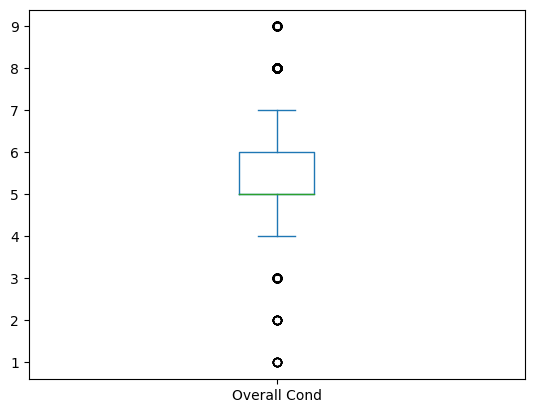

In [3]:
# Numerical and categorical
(housing
 #.assign(**{'Overall Cond': housing['Overall Cond'] + np.random.random(len(housing))*.8 -.4})
 .plot
 .box(x='Year Built', y='Overall Cond')
)

<Axes: >

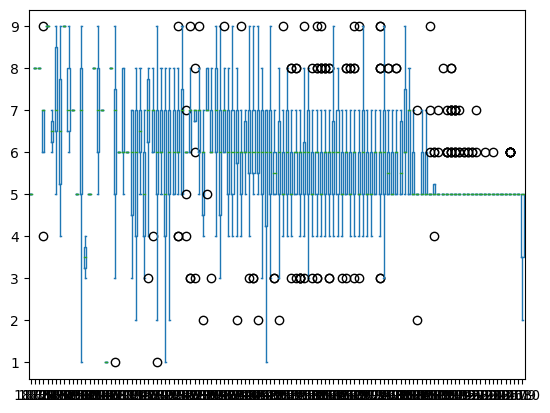

In [4]:
# Make multiple box plots
(housing
 .pivot(columns='Year Built', values='Overall Cond')
 .apply(lambda ser: ser[~ser.isna()].reset_index(drop=True))
 .plot.box()
)

<Axes: >

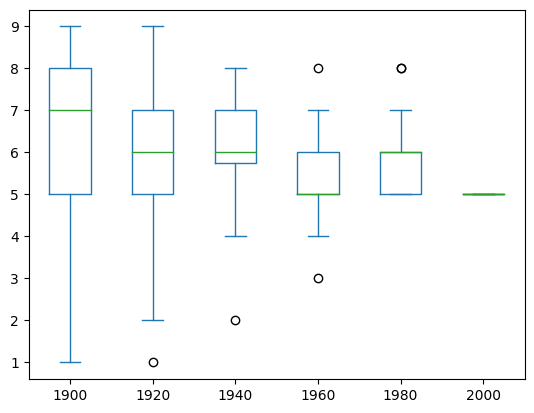

In [5]:
(housing
 .pivot(columns='Year Built', values='Overall Cond')
 .apply(lambda ser: ser[~ser.isna()].reset_index(drop=True))
 .loc[:, [1900, 1920, 1940, 1960, 1980, 2000]]
 .plot.box()
)

In [6]:
1993 // 10

199

<Axes: >

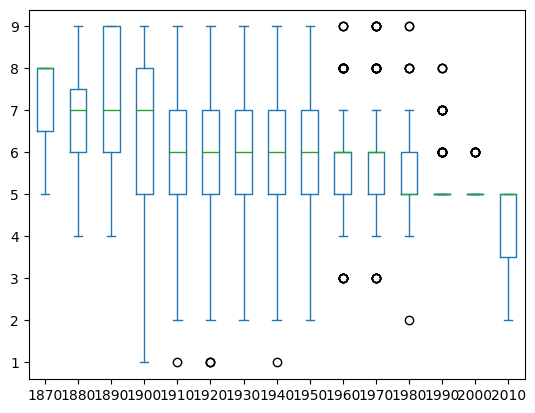

In [7]:
# Group by decade
(housing
 .assign(decade=(housing['Year Built']//10 ) * 10) # This is 'floor' division then multiply by ten
 # floor division is a quick way to put all the rows into groups by decade. This will give us a much more readable box plot.
 .pivot(columns='decade', values='Overall Cond')
 .apply(lambda ser: ser[~ser.isna()].reset_index(drop=True))
 .plot.box()
)

<Axes: xlabel='Year Built', ylabel='Overall Cond'>

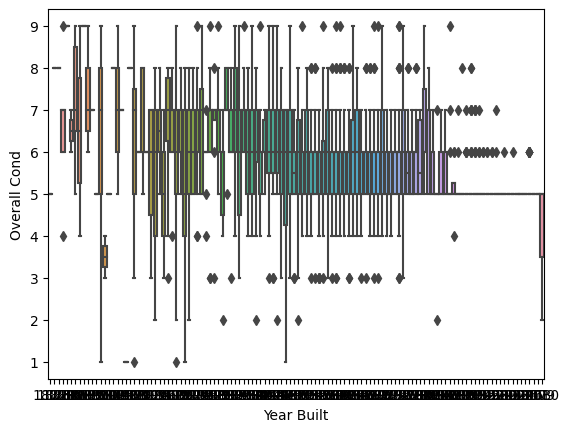

In [8]:
# or use seaborn
import seaborn as sns

sns.boxplot(data=housing, x='Year Built', y='Overall Cond')

In [9]:
sns.boxplot?

Signature:
sns.boxplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    fliersize=5,
    linewidth=None,
    whis=1.5,
    ax=None,
    **kwargs,
)
Docstring:
Draw a box plot to show distributions with respect to categories.

A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range.

.. note::
    This function always treats one of the variables as categorical and
    draws data at ordinal positions (0, 1, ... n) on the relevant axis,
    even when the data has a numeric or date type.

See th

<Axes: xlabel='Year Built', ylabel='Overall Cond'>

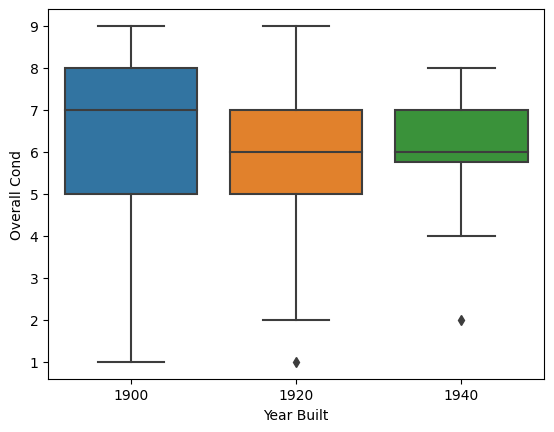

In [10]:
sns.boxplot(data=housing, x='Year Built', y='Overall Cond',
            order=[1900, 1920, 1940]
)

<Axes: xlabel='Year Built', ylabel='Overall Cond'>

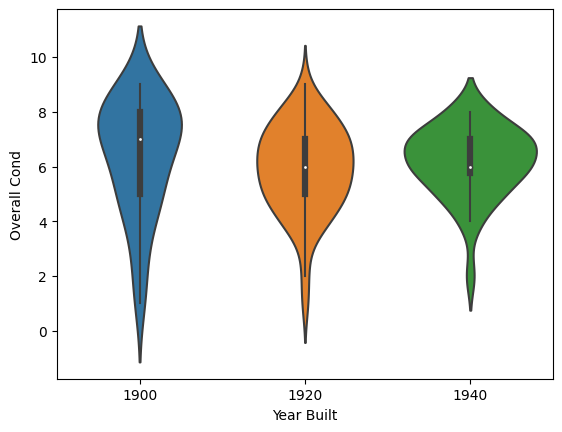

In [11]:
sns.violinplot(data=housing, x='Year Built', y='Overall Cond',
            order=[1900, 1920, 1940]
)

<Axes: xlabel='Year Built', ylabel='Overall Cond'>

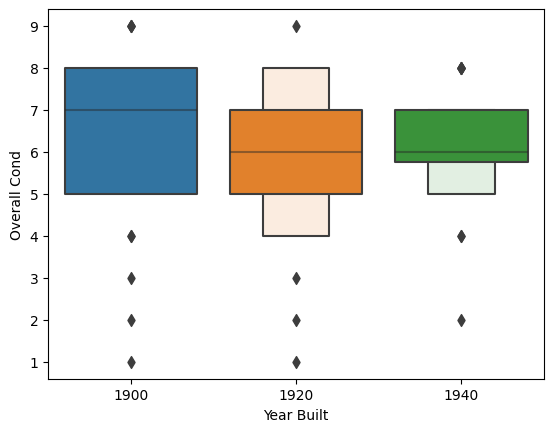

In [12]:
sns.boxenplot(data=housing, x='Year Built', y='Overall Cond',
            order=[1900, 1920, 1940]
)

### 02_07 - Comparing Two Categoricals

Goals:


* Create a cross-tabulation 
* Style the cross-tabulation table 
* Explore the documentation of the `.background_gradient` method of pandas styling.
* Create a stacked bar plot of a cross-tabulation

In [13]:
# 2 Categoricals
housing.dtypes[:40]


Order             uint16[pyarrow]
PID               uint32[pyarrow]
MS SubClass        uint8[pyarrow]
MS Zoning                category
Lot Frontage      uint16[pyarrow]
Lot Area          uint32[pyarrow]
Street                   category
Alley                    category
Lot Shape                category
Land Contour             category
Utilities                category
Lot Config               category
Land Slope               category
Neighborhood             category
Condition 1              category
Condition 2              category
Bldg Type                category
House Style              category
Overall Qual       uint8[pyarrow]
Overall Cond       uint8[pyarrow]
Year Built        uint16[pyarrow]
Year Remod/Add    uint16[pyarrow]
Roof Style               category
Roof Matl                category
Exterior 1st             category
Exterior 2nd             category
Mas Vnr Type             category
Mas Vnr Area      uint16[pyarrow]
Exter Qual               category
Exter Cond    

In [14]:
# 2 Categoricals - Cross tabulation
(housing
 .groupby(['Overall Qual', 'Bsmt Cond'])
 .size()
 .unstack()
)

Bsmt Cond,Ex,Fa,Gd,Missing,NA,Po,TA
Overall Qual,,,,,,,
1,0,0,0,0,3,1,0
2,0,4,0,0,4,0,5
3,0,9,0,0,10,0,21
4,0,16,2,1,24,1,182
5,1,39,24,0,32,2,727
6,1,28,28,0,3,0,672
7,0,5,33,0,3,0,561
8,1,3,25,0,0,1,320
9,0,0,9,0,0,0,98


In [15]:
# Do this in one line of code vs the above
(pd.crosstab(index=housing['Overall Qual'], columns=housing['Bsmt Cond']))

Bsmt Cond,Ex,Fa,Gd,Missing,NA,Po,TA
Overall Qual,,,,,,,
1,0,0,0,0,3,1,0
2,0,4,0,0,4,0,5
3,0,9,0,0,10,0,21
4,0,16,2,1,24,1,182
5,1,39,24,0,32,2,727
6,1,28,28,0,3,0,672
7,0,5,33,0,3,0,561
8,1,3,25,0,0,1,320
9,0,0,9,0,0,0,98


In [17]:
(pd.crosstab(index=housing['Overall Qual'], columns=housing['Bsmt Cond'])
 .style
 .background_gradient(cmap='viridis', axis=None)  # None is whole dataframe
)

Bsmt Cond,Ex,Fa,Gd,Missing,NA,Po,TA
Overall Qual,,,,,,,
1,0,0,0,0,3,1,0
2,0,4,0,0,4,0,5
3,0,9,0,0,10,0,21
4,0,16,2,1,24,1,182
5,1,39,24,0,32,2,727
6,1,28,28,0,3,0,672
7,0,5,33,0,3,0,561
8,1,3,25,0,0,1,320
9,0,0,9,0,0,0,98


In [18]:
raw.style.background_gradient?

Signature:
raw.style.background_gradient(
    cmap: 'str | Colormap' = 'PuBu',
    low: 'float' = 0,
    high: 'float' = 0,
    axis: 'Axis | None' = 0,
    subset: 'Subset | None' = None,
    text_color_threshold: 'float' = 0.408,
    vmin: 'float | None' = None,
    vmax: 'float | None' = None,
    gmap: 'Sequence | None' = None,
) -> 'Styler'
Docstring:
Color the background in a gradient style.

The background color is determined according
to the data in each column, row or frame, or by a given
gradient map. Requires matplotlib.

Parameters
----------
cmap : str or colormap
    Matplotlib colormap.
low : float
    Compress the color range at the low end. This is a multiple of the data
    range to extend below the minimum; good values usually in [0, 1],
    defaults to 0.
high : float
    Compress the color range at the high end. This is a multiple of the data
    range to extend above the maximum; good values usually in [0, 1],
    defaults to 0.
axis : {0, 1, "index", "columns", N

In [16]:
# Reorder
# Ex: Excellent
# Gd: Good
# TA: Typical - slight dampness allowed
# Fa: Fair - dampness or some cracking or settling
# Po: Poor - Severe cracking, settling, or wetness
    
(pd.crosstab(index=housing['Overall Qual'], columns=housing['Bsmt Cond'])
 .loc[:, ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'Missing', 'NA']]
 .style
 .background_gradient(cmap='viridis', axis=None)  # None is whole dataframe # viridis goes from purple to yellow passing through blue and green
)

Bsmt Cond,Ex,Gd,TA,Fa,Po,Missing,NA
Overall Qual,,,,,,,
1,0,0,0,0,1,0,3
2,0,0,5,4,0,0,4
3,0,0,21,9,0,0,10
4,0,2,182,16,1,1,24
5,1,24,727,39,2,0,32
6,1,28,672,28,0,0,3
7,0,33,561,5,0,0,3
8,1,25,320,3,1,0,0
9,0,9,98,0,0,0,0


<Axes: xlabel='Overall Qual'>

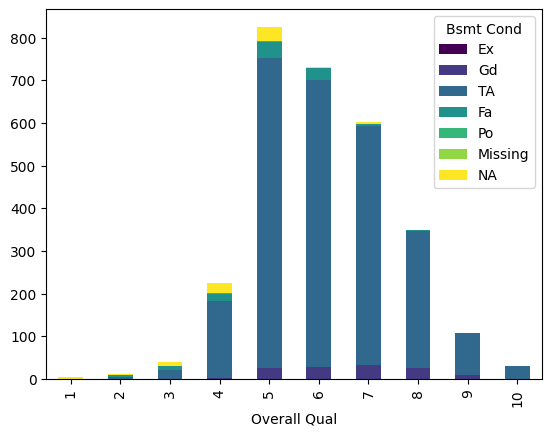

In [19]:
# Reorder
# Ex: Excellent
# Gd: Good
# TA: Typical - slight dampness allowed
# Fa: Fair - dampness or some cracking or settling
# Po: Poor - Severe cracking, settling, or wetness
    
(pd.crosstab(index=housing['Overall Qual'], columns=housing['Bsmt Cond'])
 .loc[:, ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'Missing', 'NA']]
 .plot.bar(stacked=True, 
           cmap='viridis')
)

# 2_08 Challenge  
### Create a scatter plot of 1st Floor SF (Square Footage) against SalePrice

In [26]:
housing['1st Flr SF'].value_counts().sort_values(ascending=True)
# There are 1083 different values for '1st Flr SF'
# We should narrow this down to fewer values


1st Flr SF
2110     1
763      1
1690     1
1856     1
2073     1
        ..
848     18
960     18
912     19
1040    28
864     46
Name: count, Length: 1083, dtype: int64[pyarrow]

In [33]:
(housing
 ['1st Flr SF']
 .describe()
)

count    2930.000000
mean     1159.557679
std       391.890885
min       334.000000
25%       876.250000
50%      1084.000000
75%      1384.000000
max      5095.000000
Name: 1st Flr SF, dtype: double[pyarrow]

<Axes: >

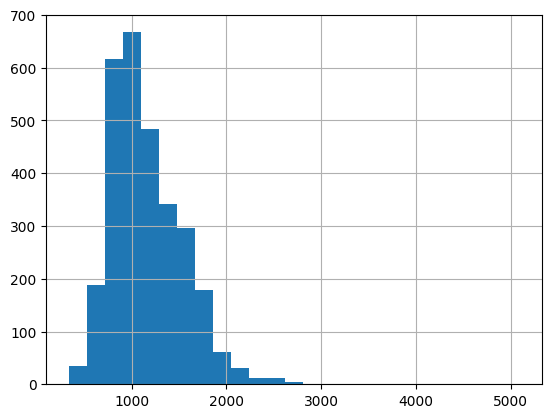

In [39]:
(housing
 ['1st Flr SF']
 .hist(bins=25)
)

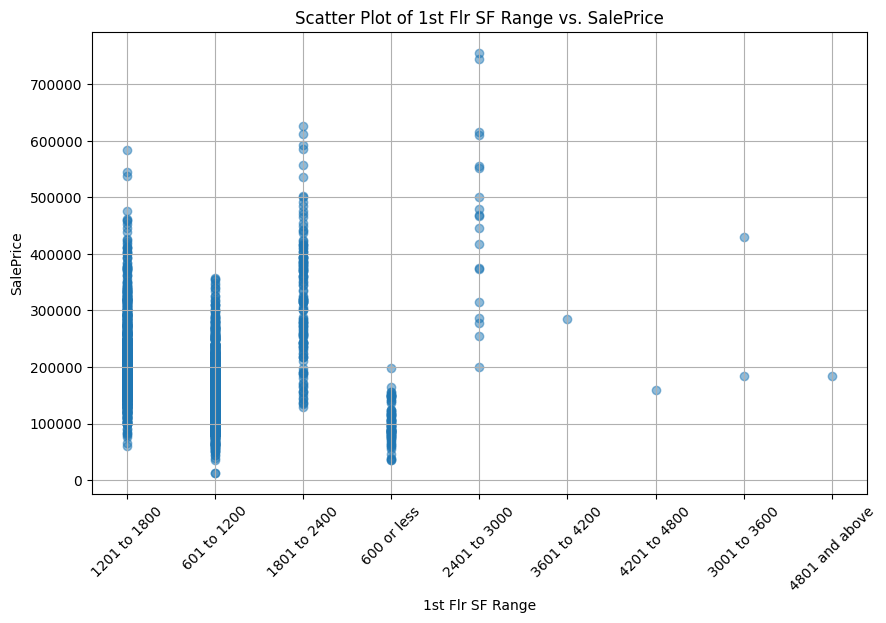

<function matplotlib.pyplot.clf()>

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Categorize '1st Flr SF' into specified ranges
bins = [0, 600, 1200, 1800, 2400, 3000, 3600, 4200, 4800, float('inf')]
labels = ['600 or less', '601 to 1200', '1201 to 1800', '1801 to 2400', '2401 to 3000', '3001 to 3600', '3601 to 4200', '4201 to 4800', '4801 and above']
housing['1st Flr SF Range'] = pd.cut(housing['1st Flr SF'], bins=bins, labels=labels)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(housing['1st Flr SF Range'], housing['SalePrice'], alpha=0.5)
plt.xlabel('1st Flr SF Range')
plt.ylabel('SalePrice')
plt.title('Scatter Plot of 1st Flr SF Range vs. SalePrice')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.clf

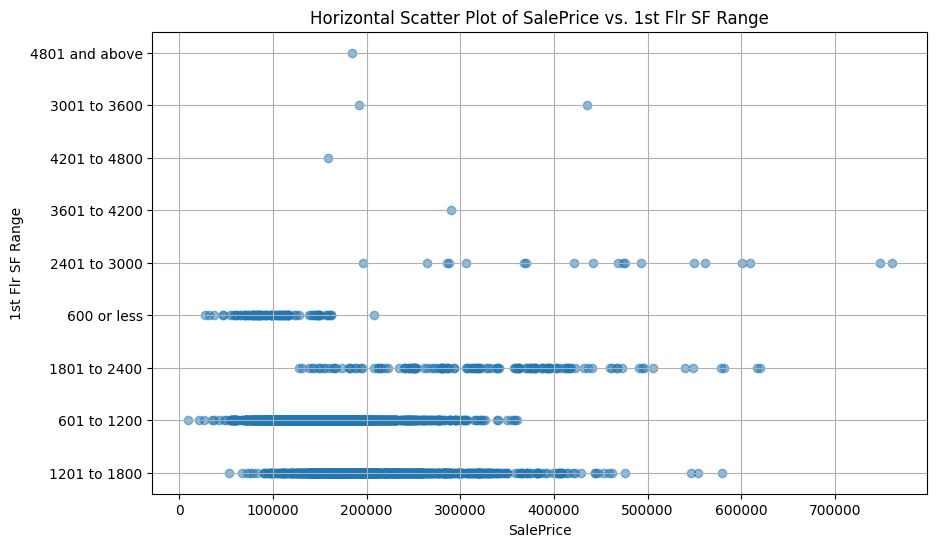

In [53]:
# Turn horizontal and Add jitter
def add_jitter(series, jitter_strength):
    return series + np.random.uniform(-jitter_strength, jitter_strength, size=series.shape)

# Plotting
plt.figure(figsize=(10, 6))
jittered_saleprice = add_jitter(housing['SalePrice'], 10000)  # Adjust jitter strength as needed
plt.scatter(jittered_saleprice, housing['1st Flr SF Range'], alpha=0.5)
plt.ylabel('1st Flr SF Range')
plt.xlabel('SalePrice')
plt.title('Horizontal Scatter Plot of SalePrice vs. 1st Flr SF Range')
plt.grid(True)
plt.show()

<Axes: xlabel='1st Flr SF', ylabel='SalePrice'>

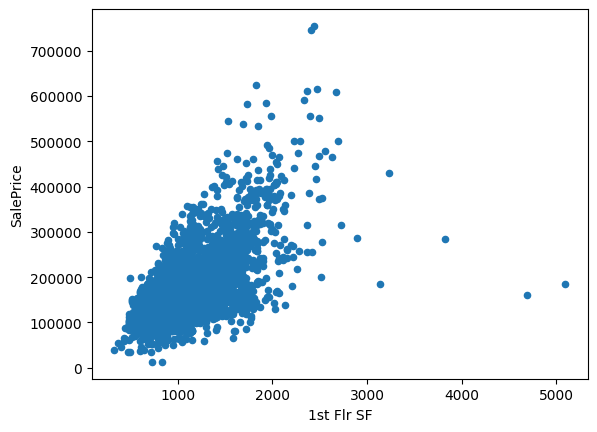

In [27]:
# basix scatter plot with dataset values unchanged
(housing
 .plot
 .scatter(x='1st Flr SF', y='SalePrice')
)

<Axes: xlabel='1st Flr SF Range', ylabel='SalePrice'>

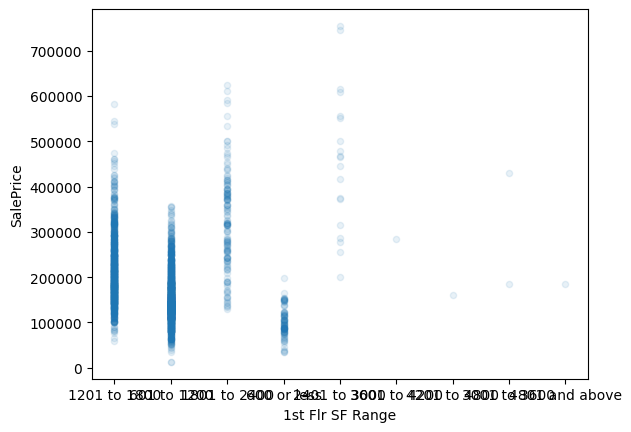

In [54]:
(housing
 .plot
 .scatter(x='1st Flr SF Range', y='SalePrice', alpha=.1)
)

<Axes: xlabel='1st Flr SF', ylabel='SalePrice'>

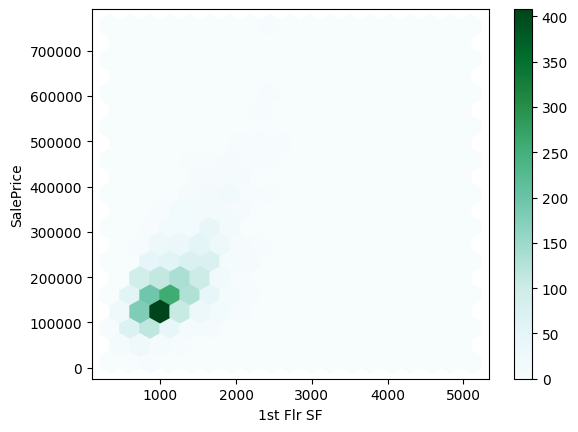

In [57]:
# using pandas 2 built in .hexbin method
(housing
 #.assign(**{'Overall Cond': housing['Overall Cond'] + np.random.random(len(housing))*.8 -.4})
 .plot
 .hexbin(x='1st Flr SF', y='SalePrice', alpha=1, gridsize=18)
)

<Axes: xlabel='SalePrice', ylabel='1st Flr SF'>

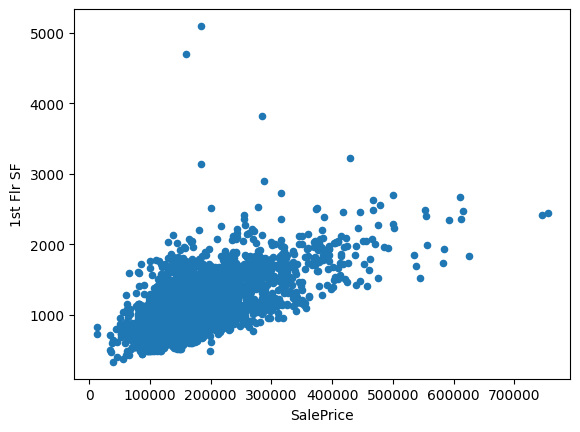

In [58]:
# Solution from Matt Harrison
(housing
 .plot.scatter(x='SalePrice', y='1st Flr SF')
)

<Axes: xlabel='SalePrice', ylabel='1st Flr SF'>

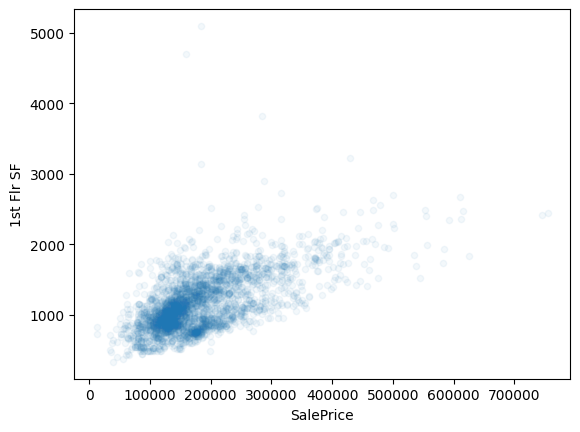

In [64]:
# Large dark areas are not good in a plot like this
# we can adjust the alpha or
# use .sample method
(housing
 #.sample(300)
 .plot.scatter(x='SalePrice', y='1st Flr SF', alpha=.05)
)